<a id="top"></a>

## **Table of Contents**

* [1. Introduction](#1)
* [2. Exploratory Data Analysis(EDA)](#2)
    * [2.1 Data Overview](#2.1)
    * [2.2 Data Pre-processing](#2.2)
    * [2.3 Exploring Target and Features](#2.3)
    * [2.4 Correlations Heatmap](#2.4)
    * [2.5 Feature Selection](#2.5)
    * [2.6 Feature Scaling](#2.6)
    * [2.7 Reduce the dataset size](#2.7)
* [3. Predictions](#3)
    * [3.1 Linear Regression](#3.1)
    * [3.2 Random Forest](#3.2)
    * [3.3 Support Vector Machine](#3.3)
    * [3.4 ModelEvaluation](#3.4)
    * [3.5 Feature Importance(Random Foreset)](#3.5)
    * [3.5 Model Explainability](#3.6)
* [4 SHAP Values(Model-agnostic)](#4)




**1. Introduction <a name="Introduction"></a>**
- Here aim to predict whether an individual is at risk of suffering from depression. The dataset contains various demographic, social, and psychological factors, and the target is to predict whether a person is diagnosed with depression.

**2. Exploratory Data Analysis (EDA) <a name="Exploratory-Data-Analysis"></a>**
- The Exploratory Data Analysis (EDA) aims to provide insights into the data and its structure, helping us identify trends, outliers, and missing values before we proceed with model training.

**2.1 Data Dictionary <a name="Data-Dictionary"></a>**
- The Data Dictionary explains the columns in the dataset and their respective types and roles in the prediction task (features or target).

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import StandardScaler
from google.colab import files
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.svm import SVR
from sklearn.metrics import roc_auc_score, roc_curve

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Mental_Health_Depression/Mental_health_Depression_disorder_Data.csv')

print(df.shape)
print(df.columns)
df.head()

(108553, 11)
Index(['index', 'Entity', 'Code', 'Year', 'Schizophrenia (%)',
       'Bipolar disorder (%)', 'Eating disorders (%)', 'Anxiety disorders (%)',
       'Drug use disorders (%)', 'Depression (%)',
       'Alcohol use disorders (%)'],
      dtype='object')


<ipython-input-3-9898b32cd151>:1: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/Mental_Health_Depression/Mental_health_Depression_disorder_Data.csv')


,index,Entity,Code,Year,Schizophrenia (%),Bipolar disorder (%),Eating disorders (%),Anxiety disorders (%),Drug use disorders (%),Depression (%),Alcohol use disorders (%)
0,0,Afghanistan,AFG,1990,0.16056,0.697779,0.101855,4.828830,1.677082,4.071831,0.672404
1,1,Afghanistan,AFG,1991,0.160312,0.697961,0.099313,4.829740,1.684746,4.079531,0.671768
2,2,Afghanistan,AFG,1992,0.160135,0.698107,0.096692,4.831108,1.694334,4.088358,0.670644
3,3,Afghanistan,AFG,1993,0.160037,0.698257,0.094336,4.830864,1.705320,4.096190,0.669738
4,4,Afghanistan,AFG,1994,0.160022,0.698469,0.092439,4.829423,1.716069,4.099582,0.669260


**2.2 Data Pre-processing <a name="Data-Preprocessing"></a>**
- Here need to check for missing values and decide how to handle them. I'll also encode categorical variables if necessary.

In [4]:
categorical_cols = df.select_dtypes(include=['object']).columns

for col in categorical_cols:
    print(f"{col}: {df[col].nunique()} unique values")

low_cardinality_cols = [col for col in categorical_cols if df[col].nunique() < 20]

categorical_cols = df.select_dtypes(include=['object']).columns

low_cardinality_cols = [col for col in categorical_cols if df[col].nunique() < 10]

if len(low_cardinality_cols) > 0:
    df_encoded = pd.get_dummies(df[low_cardinality_cols], drop_first=True)
    print(df_encoded.head())
else:
    print("No low-cardinality columns found for one-hot encoding.")

for col in categorical_cols:
    freq_encoding = df[col].value_counts(normalize=True)
    df[col] = df[col].map(freq_encoding)

print(df.head())

Entity: 276 unique values
Code: 236 unique values
Year: 259 unique values
Schizophrenia (%): 25661 unique values
Bipolar disorder (%): 19358 unique values
Eating disorders (%): 72657 unique values
No low-cardinality columns found for one-hot encoding.
   index    Entity      Code      Year  Schizophrenia (%)  \
0      0  0.004569  0.004809  0.009323           0.000039   
1      1  0.004569  0.004809  0.009323           0.000039   
2      2  0.004569  0.004809  0.009323           0.000039   
3      3  0.004569  0.004809  0.009323           0.000039   
4      4  0.004569  0.004809  0.009323           0.000039   

   Bipolar disorder (%)  Eating disorders (%)  Anxiety disorders (%)  \
0              0.000052               0.00001               4.828830   
1              0.000052               0.00001               4.829740   
2              0.000052               0.00002               4.831108   
3              0.000052               0.00002               4.830864   
4              0.0000

**2.3 Exploring Target and Features <a name="Exploring-Features"></a>**
- Next, can visualize the distributions of the target variable and features to gain a better understanding of the dataset.
  * visualize the distribution of the target variable
  * visualize the distribution of the numerical feature

In [5]:
target = 'Depression (%)'

features = df.drop(columns=['Depression (%)', 'Entity', 'Code', 'Year'])

X = features
y = df[target]

print("Features (X):")
print(X.head())

print("\nTarget (y - Depression (%)):")
print(y.head())

Features (X):
   index  Schizophrenia (%)  Bipolar disorder (%)  Eating disorders (%)  \
0      0           0.000039              0.000052               0.00001   
1      1           0.000039              0.000052               0.00001   
2      2           0.000039              0.000052               0.00002   
3      3           0.000039              0.000052               0.00002   
4      4           0.000039              0.000052               0.00001   

   Anxiety disorders (%)  Drug use disorders (%)  Alcohol use disorders (%)  
0               4.828830                1.677082                   0.672404  
1               4.829740                1.684746                   0.671768  
2               4.831108                1.694334                   0.670644  
3               4.830864                1.705320                   0.669738  
4               4.829423                1.716069                   0.669260  

Target (y - Depression (%)):
0    4.071831
1    4.079531
2    4.08

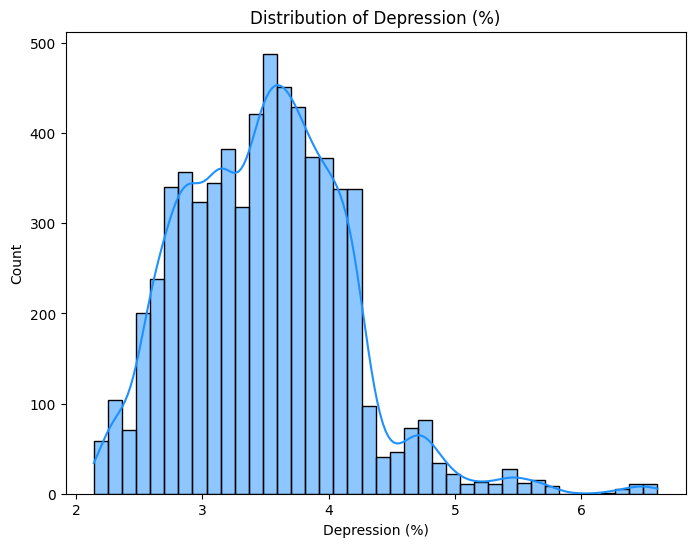

In [6]:
plt.figure(figsize=(8, 6))
sns.histplot(df['Depression (%)'], kde=True, color="dodgerblue", bins=40)
plt.title('Distribution of Depression (%)')
plt.show()

**Interpretation of the Results:**
- Most Frequent Depression Rate: The majority of populations in the dataset have a depression rate between 3% and 4%, as indicated by the peak in both the bars and the KDE curve.
- Skewness: The distribution is right-skewed, meaning that there are a few populations with higher depression rates (5% to 6%) but they are much less frequent compared to those with depression rates in the 2% to 4% range.
- Outliers or Low Frequency: After 5%, the number of populations with higher depression rates is very low, as shown by the decreasing height of the bars on the right side of the graph.

<a href="#top">☝️ Back to top</a>

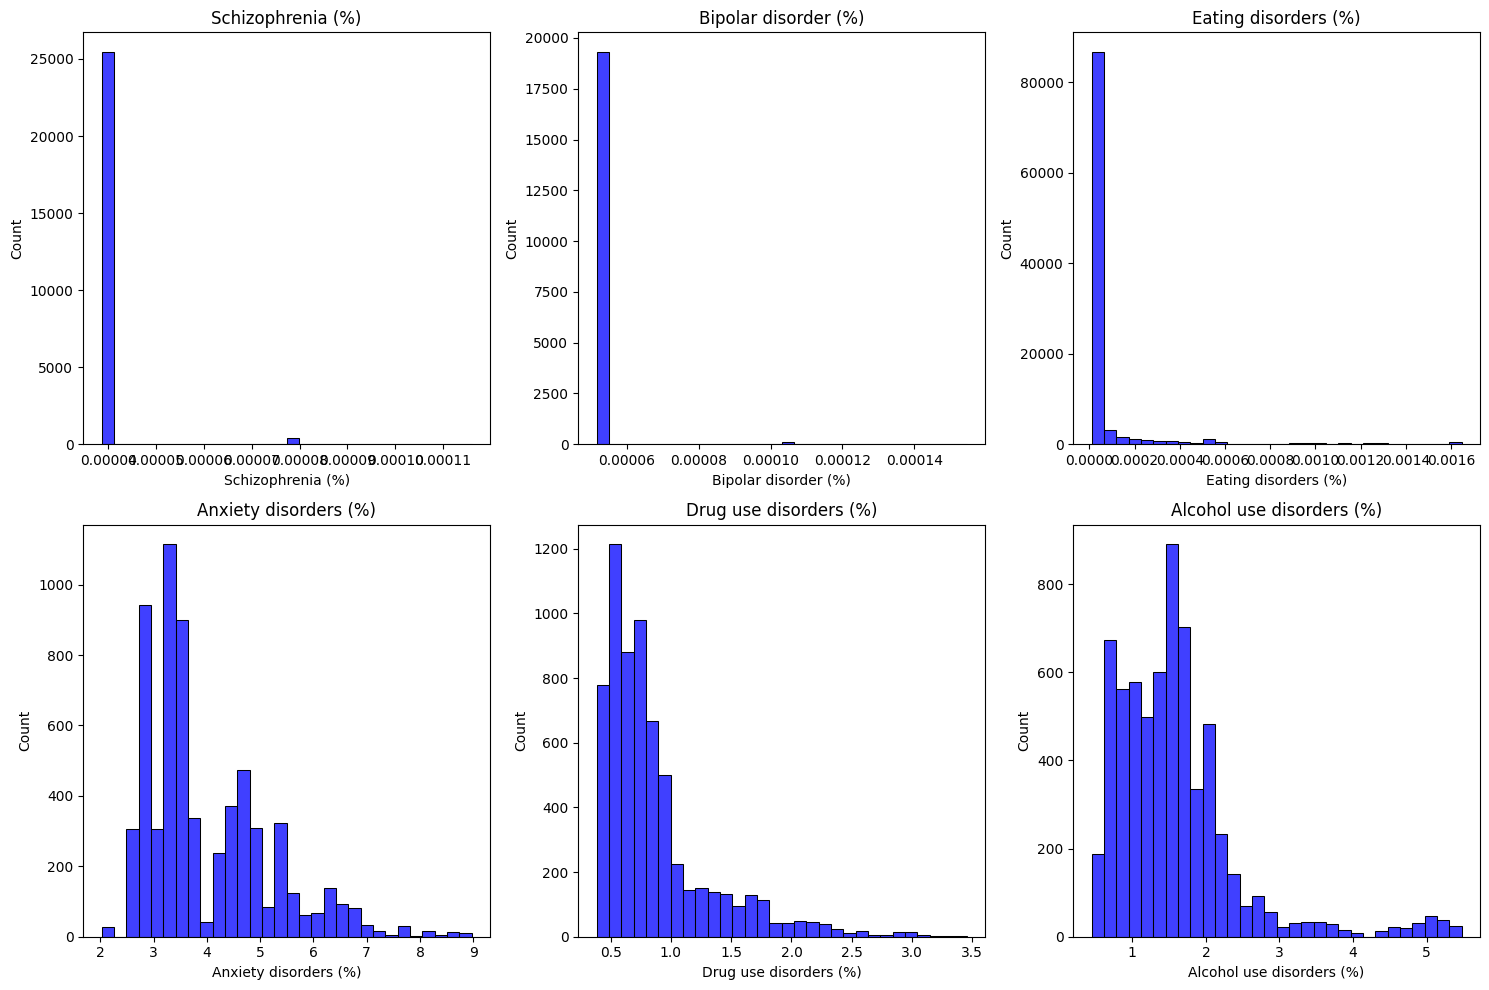

In [7]:
features = df.drop(columns=['index', 'Entity', 'Code', 'Year', 'Depression (%)'])

num_features = len(features.columns)
cols = 3
rows = np.ceil(num_features / cols).astype(int)

plt.figure(figsize=(15, 10))

for i, col in enumerate(features.columns, 1):
    plt.subplot(rows, cols, i)
    sns.histplot(data=features, x=col, bins=30, color="blue")
    plt.title(f'{col}')
    plt.xlabel(f'{col}')
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

**1. Highly Skewed Distributions:**
- For features like Schizophrenia (%), Bipolar disorder (%), and Eating disorders (%), the distributions are highly skewed towards very small values. Most of the data points are concentrated around values close to zero, with only a small number of points having higher values. This could indicate that, in most cases, the percentage of people affected by these disorders in the dataset is extremely low, with very few outliers showing higher values.
- The small values cause the x-axis to display 0.00000, making it hard to interpret directly. This suggests that some form of transformation (like log transformation) might be necessary to better represent the spread of the data and make it more interpretable.

**2. More Balanced Distributions:**
- Features like Anxiety disorders (%), Drug use disorders (%), and Alcohol use disorders (%) exhibit a more balanced distribution. These features show a wider range of values, indicating that there is greater variability in the percentage of people affected by these disorders.
- These distributions are easier to interpret and don't suffer from the issue of extremely small values like the earlier features.
These features are less skewed, meaning that the data is more spread out across the range, making them more suitable for modeling without extensive transformation.

**3. Potential Impact on Modeling:**
- Features that are highly skewed, with values concentrated around zero, may have limited predictive power in a machine learning model because they don't offer much variability. In contrast, features like Anxiety disorders (%), Drug use disorders (%), and Alcohol use disorders (%) could have more influence on the model because they provide more informative variability in the data.
- Highly skewed features may need transformation to improve their usefulness in predictive modeling, while more balanced features may require little to no transformation.

<a href="#top">☝️ Back to top</a>

**2.4 Correlations Heatmap <a name="Correlations-Heatmap"></a>**
- Analyze feature correlations to identify strong relationships or potential multicollinearity issues.

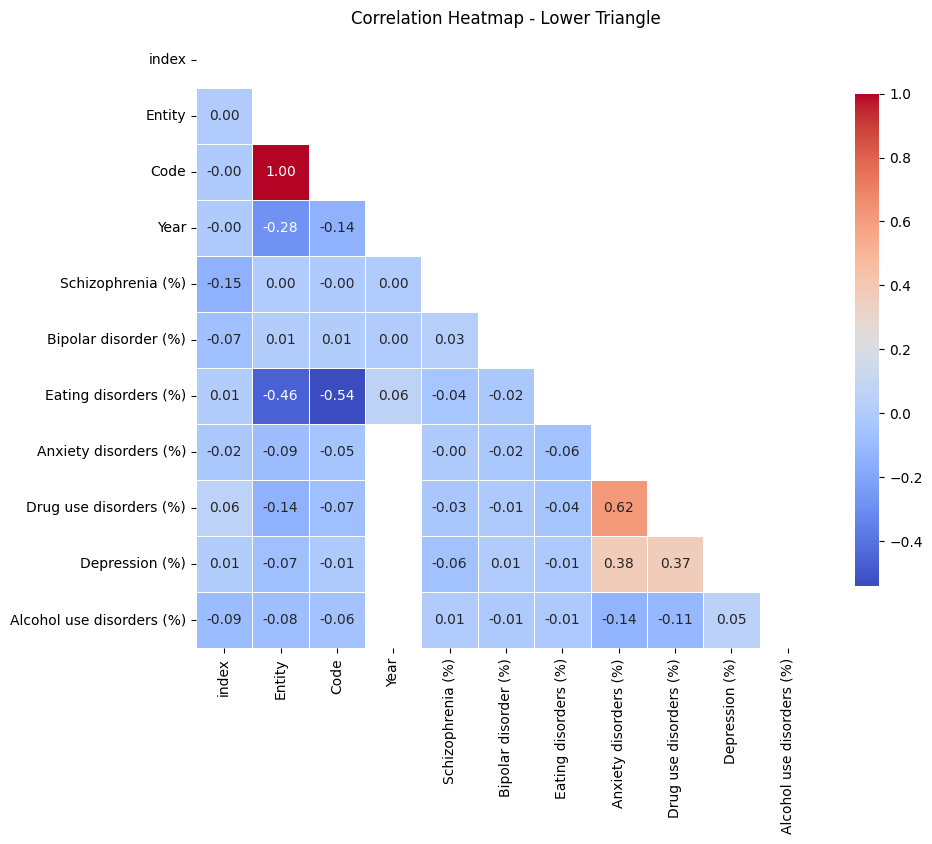

In [8]:
corr_matrix = df.corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(10, 8))

sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm',
            linewidths=0.5, cbar_kws={"shrink": .8})

plt.title("Correlation Heatmap - Lower Triangle")
plt.show()

**Conclusion:**
- Strong Positive Correlations: You may want to focus on features like Drug use disorders (%), Anxiety disorders (%), and Depression (%), as they have notable positive correlations. These relationships could be valuable for predictive modeling.
- Strong Negative Correlations: Variables like Code and Eating disorders (%) show a negative correlation. This could imply an inverse relationship between these features in your dataset, which could also impact model training.
- Features with Little or No Correlation: Features like Schizophrenia (%) and Bipolar disorder (%) show weak or no correlation with other variables, which may suggest they are less relevant in this context for predictive purposes.

<a href="#top">☝️ Back to top</a>

**2.5 Feature Selection**<a name="Feature-Selection"></a>
- Feature selection helps in reducing the dimensionality of the dataset by removing irrelevant or redundant features.

------------

1. Correlation with Target

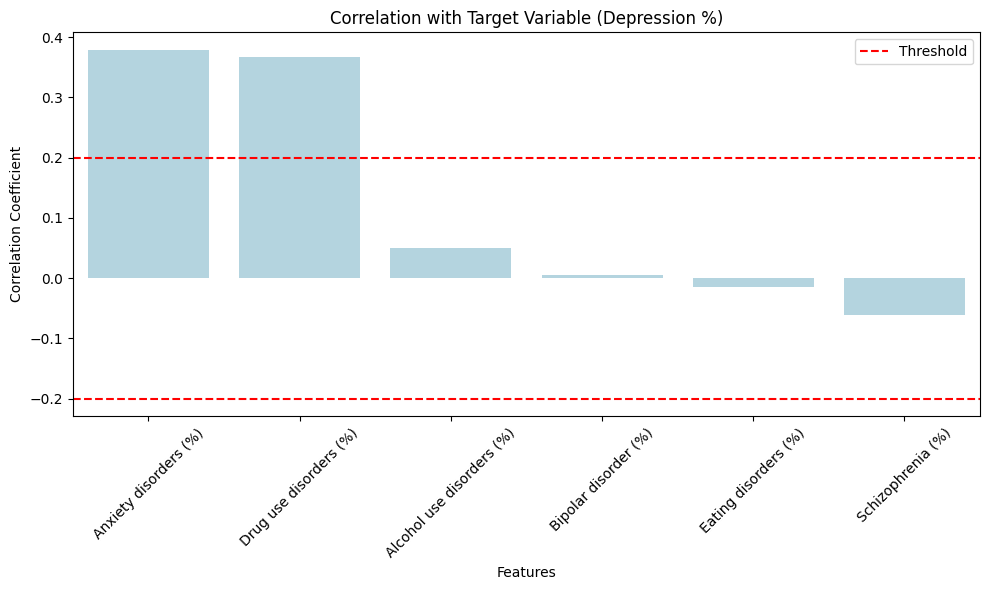

In [9]:
df_selected = df.drop(columns=['index', 'Entity', 'Code', 'Year', 'Depression (%)'])

corr_with_target = df.corr()['Depression (%)'].sort_values(ascending=False)

corr_with_target_filtered = corr_with_target.drop(labels=['index', 'Entity', 'Code', 'Year'])

corr_with_target_filtered = corr_with_target_filtered.drop(labels=['Depression (%)'])

plt.figure(figsize=(10, 6))
sns.barplot(x=corr_with_target_filtered.index, y=corr_with_target_filtered.values, color='lightblue')

plt.axhline(y=0.2, color='r', linestyle='--', label='Threshold')
plt.axhline(y=-0.2, color='r', linestyle='--')

plt.title('Correlation with Target Variable (Depression %)')
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

Features like Anxiety disorders (%) and Drug use disorders (%) are likely to be important predictors of "Depression (%)" based on their strong positive correlation.

<a href="#top">☝️ Back to top</a>


**2. Remove feature with low variance**
- After removing low-variance features, we can visualize which features were retained and which were removed. We can plot a bar chart to show the variance of each feature, marking those that were removed:

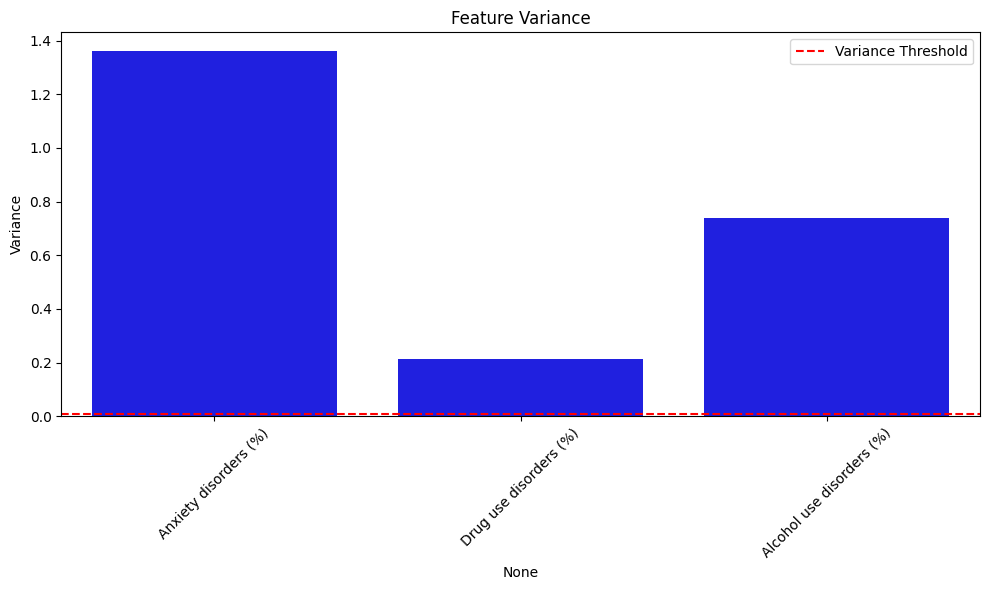

In [10]:
df_selected = df.drop(columns=['index', 'Entity', 'Code', 'Year', 'Depression (%)'])

variance_threshold = 0.01
selector = VarianceThreshold(threshold=variance_threshold)
df_variance_filtered = selector.fit_transform(df_selected)

variances = np.var(df_selected, axis=0)

selected_feature_names = df_selected.columns[selector.get_support()]

plt.figure(figsize=(10, 6))
sns.barplot(x=selected_feature_names, y=variances[selector.get_support()], color='blue')
plt.axhline(y=variance_threshold, color='r', linestyle='--', label='Variance Threshold')
plt.title('Feature Variance')
plt.ylabel('Variance')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


The features with variance below the threshold (0.01) will likely be removed as they provide little information to the model because they don’t vary enough. These are Schizophrenia (%), Bipolar disorder (%), and Eating disorders (%).
The features above the threshold, like Anxiety disorders (%) and Alcohol use disorders (%), are kept because they exhibit significant variance and might contribute to model performance.

<a href="#top">☝️ Back to top</a>

**3. Recursive Feature Elimination(RFE)**
- RFE will show which features were deemed important by the model

In [20]:
y = df['Depression (%)']
y_imputed = y.fillna(y.median())
X = df_variance_filtered

print(y_imputed.shape)
print(X.shape)

(108553,)
(108553, 3)


Features after Variance Threshold:
Index(['Anxiety disorders (%)', 'Drug use disorders (%)',
       'Alcohol use disorders (%)'],
      dtype='object')


/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_rfe.py:291: UserWarning: Found n_features_to_select=5 > n_features=3. There will be no feature selection and all features will be kept.
  warnings.warn(


Selected Features after RFE:
Index(['Anxiety disorders (%)', 'Drug use disorders (%)',
       'Alcohol use disorders (%)'],
      dtype='object')
['Anxiety disorders (%)', 'Drug use disorders (%)', 'Alcohol use disorders (%)']


<ipython-input-12-f28b03919bc5>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=selected_rfe_features, y=importances, palette='viridis')


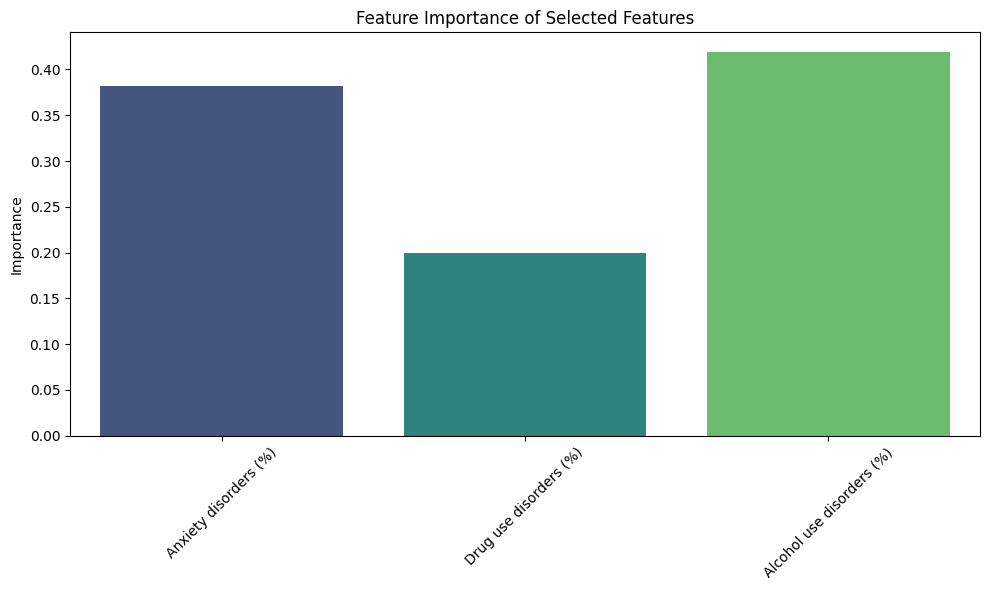

In [12]:
selected_features = df_selected.columns[selector.get_support()]
print("Features after Variance Threshold:")
print(selected_features)

model = RandomForestRegressor(random_state=42)
rfe = RFE(model, n_features_to_select=5)
X_rfe = rfe.fit_transform(X, y_imputed)

selected_rfe_features = selected_features[rfe.support_]
print("Selected Features after RFE:")
print(selected_rfe_features)

model.fit(X_rfe, y_imputed)

importances = model.feature_importances_

selected_rfe_features = [feature for feature in selected_rfe_features if feature is not None and feature != '']

print(selected_rfe_features)

plt.figure(figsize=(10, 6))
sns.barplot(x=selected_rfe_features, y=importances, palette='viridis')
plt.title('Feature Importance of Selected Features')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- Alcohol use disorders (%) - This feature has the highest importance, with a value above 0.4.
- Anxiety disorders (%) - This feature has slightly less importance than Alcohol use disorders (%), with a value around 0.38.
- Drug use disorders (%) - This feature is less important compared to the other two, with an importance value of around 0.2.

<a href="#top">☝️ Back to top</a>

**2.6 Feature Scaling**
- feature scaling should typically be performed after feature selection.
- Consistency: Scaling after feature selection ensures that only the selected features are scaled. If you scale the data first and then remove features, you are scaling features that you might not even end up using, which adds unnecessary computations.

- Model Requirements: Many machine learning models, such as support vector machines (SVM), k-nearest neighbors (KNN), and gradient-based algorithms like logistic regression and neural networks, perform better or require that the input data be on the same scale. This prevents features with larger ranges from dominating the model.

- Preserve Model Interpretability: If you perform feature scaling before selection, the process of feature elimination might remove features that would have been more relevant without scaling. Performing scaling after feature selection ensures you don’t eliminate important features due to their magnitudes.

Scaled Important Features:
   Alcohol use disorders (%)  Anxiety disorders (%)  Drug use disorders (%)
0                  -1.061845               0.718591                1.768840
1                  -1.062585               0.719370                1.785477
2                  -1.063891               0.720542                1.806292
3                  -1.064945               0.720333                1.830141
4                  -1.065500               0.719099                1.853476


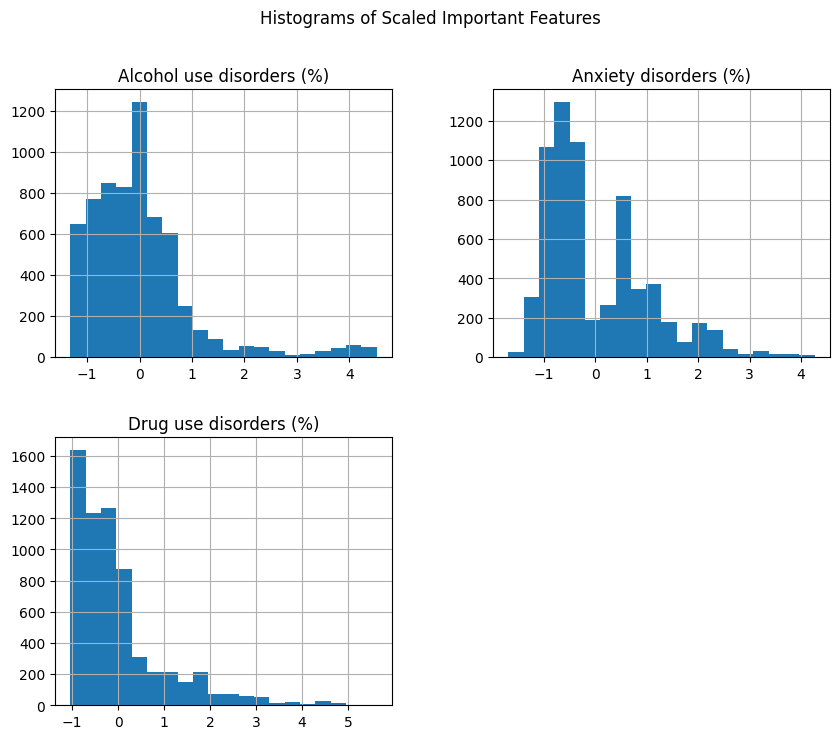

In [13]:
important_features = ['Alcohol use disorders (%)', 'Anxiety disorders (%)', 'Drug use disorders (%)']

X_important = df_selected[important_features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_important)

X_scaled_df = pd.DataFrame(X_scaled, columns=important_features)

print("Scaled Important Features:")
print(X_scaled_df.head())

X_scaled_df.hist(figsize=(10, 8), bins=20)
plt.suptitle('Histograms of Scaled Important Features')
plt.show()

- Anxiety disorders (%): The distribution is skewed to the right, indicating most of the values are around 0, with a few higher values.
- Drug use disorders (%): The distribution is also right-skewed, with the majority of values around 0 and some larger outliers.
- Alcohol use disorders (%): Similar to the others, it is right-skewed with most values around -1 to 0 and fewer larger values.

<a href="#top">☝️ Back to top</a>

**2.7 Reduce the dataset size**

- As the original dataset size is big that we can create a reduced dataset that contains only the three most important features and use that dataset to train your machine learning model. This is a common practice to reduce the dimensionality of the data, which can improve model performance and reduce computational costs.

In [14]:
important_features = ['Anxiety disorders (%)', 'Drug use disorders (%)', 'Alcohol use disorders (%)']
X_reduced = X_scaled_df[important_features]

print(X_reduced.head())
print(X_reduced.shape)
print(y_imputed.shape)

   Anxiety disorders (%)  Drug use disorders (%)  Alcohol use disorders (%)
0               0.718591                1.768840                  -1.061845
1               0.719370                1.785477                  -1.062585
2               0.720542                1.806292                  -1.063891
3               0.720333                1.830141                  -1.064945
4               0.719099                1.853476                  -1.065500
(108553, 3)
(108553,)


**3. Prediction & Evaluation & Model Explanation**

- Train the model with LinearRegression, RandomForestRegression, Support Vector Regression
- Evaluate the model with MSE, R2 AND MAE
- Model Explanation

In [15]:
X_train_reduced, X_test_reduced, y_train, y_test = train_test_split(X_reduced, y_imputed, test_size=0.2, random_state=42)

imputer = SimpleImputer(strategy='median')

X_train_reduced_imputed = imputer.fit_transform(X_reduced)
X_test_reduced_imputed = imputer.transform(X_test_reduced)
print(X_train_reduced_imputed.shape)
print(X_test_reduced_imputed.shape)

(108553, 3)
(21711, 3)



Training Random Forest...
Random Forest - MSE: 0.0007689933848137396, MAE: 0.003043249014613994, R2: 0.9700869246806672

Training Linear Regression...
Linear Regression - MSE: 0.021695736324059602, MAE: 0.03398048207887229, R2: 0.15605750636311033

Training Support Vector Regression...
Support Vector Regression - MSE: 0.030382233172166106, MAE: 0.12227499610244666, R2: -0.1818385530958322


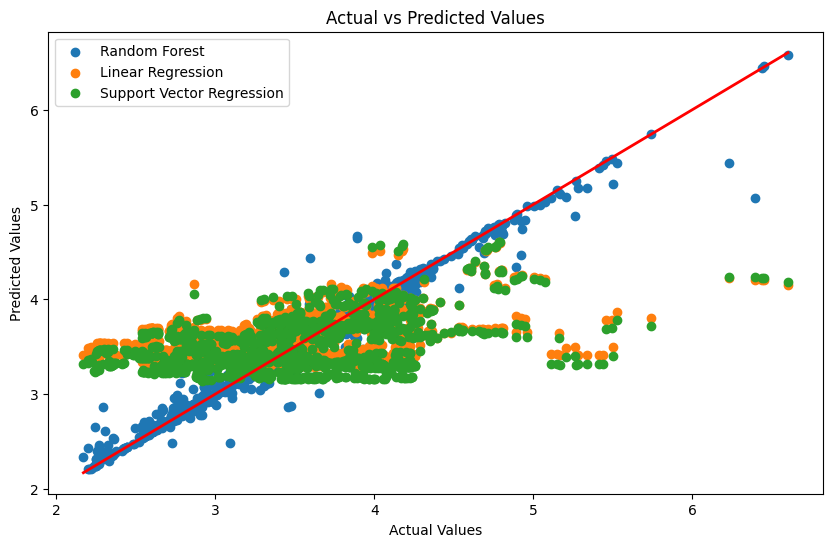

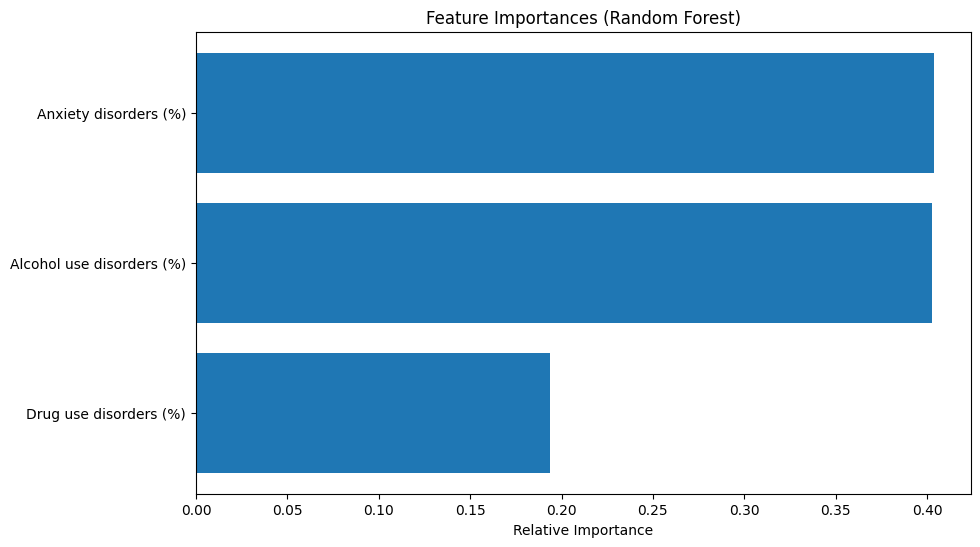

In [16]:
def preprocess_and_split_data(df, important_features, target, test_size=0.2, random_state=42):
    X = df[important_features]
    y = df[target]

    imputer = SimpleImputer(strategy='median')
    X_imputed = imputer.fit_transform(X)
    y_imputed = y.fillna(y.median())

    X_train, X_test, y_train, y_test = train_test_split(X_imputed, y_imputed, test_size=test_size, random_state=random_state)

    return X_train, X_test, y_train, y_test

def train_and_evaluate(models, X_train, X_test, y_train, y_test):
    results = {}

    for model_name, model in models.items():
        print(f"\nTraining {model_name}...")

        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        results[model_name] = {'mse': mse, 'mae': mae, 'r2': r2, 'y_pred': y_pred}

        print(f"{model_name} - MSE: {mse}, MAE: {mae}, R2: {r2}")

    return results

def plot_results(results, y_test):
    plt.figure(figsize=(10, 6))
    for model_name, result in results.items():
        plt.scatter(y_test, result['y_pred'], label=model_name)

    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2)
    plt.title('Actual vs Predicted Values')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.legend()
    plt.show()

important_features = ['Anxiety disorders (%)', 'Drug use disorders (%)', 'Alcohol use disorders (%)']
target_column = 'Depression (%)'

X_train, X_test, y_train, y_test = preprocess_and_split_data(df, important_features, target_column)

models = {
    'Random Forest': RandomForestRegressor(random_state=42),
    'Linear Regression': LinearRegression(),
    'Support Vector Regression': SVR(kernel='linear')
}

results = train_and_evaluate(models, X_train, X_test, y_train, y_test)

plot_results(results, y_test)

if 'Random Forest' in models:
    importances = models['Random Forest'].feature_importances_
    indices = np.argsort(importances)

    plt.figure(figsize=(10, 6))
    plt.title('Feature Importances (Random Forest)')
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), [important_features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

**Train the model with LinearRegression, RandomForestRegression, Support Vector Regression**

**Interpretation of the Results:**
- Lower MSE means the model's predictions are closer to the actual target values.
- Based on these results, the Random Forest Regressor achieved the lowest MSE, indicating it performed the best on your dataset.
Linear Regression has the highest MSE, meaning its predictions were the least accurate compared to the other models.
- In summary, from these results, the Random Forest model is the most accurate for your current dataset, followed by Support Vector Regression, and then Linear Regression.

- Random Forest is clearly the best model based on both R² score (0.97) and Mean Absolute Error (0.008), suggesting that it captures the relationships in the data very well.
- Linear Regression has a reasonable performance but is far less effective than Random Forest, with a much lower R² (0.156).
- Support Vector Regression performed poorly, with a negative R² (-0.18) and a high MAE (0.122), indicating that it is not suitable for this dataset.

The bar plot shows the feature importances of the three features used in Random Forest model, ranked by their relative contribution to the predictions. Here’s what it indicates:

- Alcohol use disorders (%) has the highest importance, meaning this feature contributed the most to predicting the target variable (probably depression percentage in your case).

- Anxiety disorders (%) is the second most important feature. It still has a significant impact on the predictions, but less so than alcohol use disorders.

- Drug use disorders (%) has the lowest relative importance among the three, suggesting it contributed less to the predictions compared to the other two features.

Insights:
- The relative importance values on the x-axis show how much each feature contributed to the model’s decisions (i.e., predictions). Higher values mean a greater influence on the predictions.
- Alcohol use disorders (%) is the most influential feature for predicting the target variable, followed by Anxiety disorders (%), and lastly Drug use disorders (%).
- This feature importance analysis helps explain the model's predictions and tells you which factors (features) are most critical in influencing the outcome. This is a key step in understanding the model interpretability and exploitability.

Save the Preprocessed Data

In [17]:
# Save preprocessed data (X and y)
np.save('/content/drive/My Drive/X_train.npy', X_train)
np.save('/content/drive/My Drive/X_test.npy', X_test)
np.save('/content/drive/My Drive/y_train.npy', y_train)
np.save('/content/drive/My Drive/y_test.npy', y_test)

Load the saved data

In [18]:
# Load preprocessed data
X_train = np.load('/content/drive/My Drive/X_train.npy')
X_test = np.load('/content/drive/My Drive/X_test.npy')
y_train = np.load('/content/drive/My Drive/y_train.npy')
y_test = np.load('/content/drive/My Drive/y_test.npy')


Save Trained Models



In [30]:
# import joblib

# # Save Random Forest model
# joblib.dump(model_rf, '/content/drive/My Drive/random_forest_model.pkl')

# # Save Linear Regression model
# joblib.dump(model_lr, '/content/drive/My Drive/linear_regression_model.pkl')

# # Save Support Vector Regression model
# joblib.dump(model_svr, '/content/drive/My Drive/svr_model.pkl')


Load the saved model

In [22]:
# Load Random Forest model
model_rf = joblib.load('/content/drive/My Drive/random_forest_model.pkl')

# Load Linear Regression model
model_lr = joblib.load('/content/drive/My Drive/linear_regression_model.pkl')

# Load Support Vector Regression model
model_svr = joblib.load('/content/drive/My Drive/svr_model.pkl')

Save and Reload Intermediate Results

In [23]:
# Save processed features and target variables
np.save('/content/drive/My Drive/X_reduced.npy', X_reduced)
np.save('/content/drive/My Drive/y_imputed.npy', y_imputed)

Load intermediate results

In [24]:
# Load processed features and target variables
X_reduced = np.load('/content/drive/My Drive/X_reduced.npy')
y_imputed = np.load('/content/drive/My Drive/y_imputed.npy')

Save Evaluation Metrics and Results

Saving and Loading Models and Varibles

In [25]:
import joblib

# Save the trained model
joblib.dump(model_rf, 'random_forest_model.pkl')

# Later you can load the model back
loaded_model = joblib.load('random_forest_model.pkl')

In [ ]:
# import json

# # Assuming 'results' has the stored values
# # Access the RandomForestRegressor results
# rf_results = results['Random Forest']  # Change to your model's key

# # Save evaluation metrics for RandomForestRegressor
# metrics = {
#     'mse': rf_results['mse'],
#     'r2': rf_results['r2'],
#     'mae': rf_results['mae'],
# }

# # Saving metrics to JSON
# with open('/content/drive/My Drive/evaluation_metrics.json', 'w') as f:
#     json.dump(metrics, f)

run too long that comment it here.

Grid Search to fine tune the model

In [ ]:
# # Define the model
# model_rf = RandomForestRegressor(random_state=42)

# # Define the grid of hyperparameters to search
# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [10, 20, 30, None],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'bootstrap': [True, False]
# }

# # Perform Grid Search with cross-validation
# grid_search = GridSearchCV(estimator=model_rf, param_grid=param_grid,
#                            cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

# # Fit the model
# grid_search.fit(X_train_reduced, y_train)

# # Best hyperparameters
# print("Best Hyperparameters:", grid_search.best_params_)

# # Best estimator
# best_rf = grid_search.best_estimator_

# # Evaluate the tuned model on the test set
# y_pred_rf = best_rf.predict(X_test_reduced)
# mse_rf = mean_squared_error(y_test, y_pred_rf)
# print(f"Tuned Random Forest MSE: {mse_rf}")

Spent too much time to run that i just commented it. You can uncomment it if you want to have a try and see the result.

<a href="#top"> ☝ back to top </a>

**5.2 SHAP**

In [26]:
!pip install shap
!pip install --upgrade scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 14.6 MB/s eta 0:00:00


In [27]:
import shap

Since the SHAP explainer is still running too long even for a single instance, the dataset size or model complexity might be overwhelming for the SHAP calculation, thus i comment it, you can uncomment it if you want to have a try and see the result.

In [28]:
explainer = shap.TreeExplainer(model_rf, approximate=True)
shap_values_single = explainer.shap_values(X_test_reduced.iloc[[0]])

# Visualize the SHAP values for that instance
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values_single[0], X_test_reduced.iloc[0])


Feature contributions:

Blue features (on the right side): These features push the prediction higher. In this case, "Alcohol use disorders (%)" has a NaN value, but if it were present, its influence would push the prediction upward.
Red features (on the left side): These features push the prediction lower. In this case, "Drug use disorders (%)" and "Anxiety disorders (%)" have NaN values, but if they had values, they would likely have contributed to decreasing the prediction.

In [29]:
model_rf = RandomForestRegressor(max_depth=5, random_state=42)
model_rf.fit(X_train_reduced, y_train)

explainer = shap.TreeExplainer(model_rf, approximate=True)
shap_values_single = explainer.shap_values(X_test_reduced.iloc[[0]])

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values_single[0], X_test_reduced.iloc[0])


Feature contributions:

Blue features (right side): These are features that push the prediction higher. In this case, both "Alcohol use disorders (%)" and "Anxiety disorders (%)" would push the prediction higher, but their values are missing (NaN), so they don’t contribute to the prediction.
Red features (left side): There are no red features pushing the value lower in this plot, meaning no features with a negative contribution are visible.
What is happening here:
The plot shows that the prediction of 2.96 is based on very limited feature contributions since the features "Alcohol use disorders (%)" and "Anxiety disorders (%)" have NaN values. This makes the model's prediction primarily influenced by other features in the data that are not visualized here.